In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


2024-12-23 07:42:52.766893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 07:42:52.766954: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 07:42:52.766995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 데이터 로드

# 증강 데이터
df_mask_boxout = pd.read_csv('/workspace/Data_Augumentation/out_box_masking/label/train/mask_boxout.csv')
df_crop_face = pd.read_csv('/workspace/Data_Augumentation/segmentation_face/label/train/face_only_train.csv')

In [3]:
# 이미지 경로 열 생성

df_mask_boxout['img_path'] = df_mask_boxout['path'] + df_mask_boxout['filename']
df_crop_face['img_path'] = df_crop_face['path'] + df_crop_face['filename']


In [4]:
# 데이터 로드
target_size = (224,224)     # 모델 입력에 맞는 사이즈 설정
num_classes = len(df_mask_boxout['faceExp_uploader'].unique())  # 클래스 수 계산

# ImageDataGenerator 정의 
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # 픽셀 값 정규화 [-1, 1]

# mask boxout 데이터 generator 정의
mask_boxout_generator = datagen.flow_from_dataframe(
    dataframe=df_mask_boxout,         # Pandas DataFrame with image paths and labels
    directory=None,                   # Root directory for relative image paths
    x_col='img_path',                 # Column name in DataFrame containing image file paths
    y_col='faceExp_uploader',         # Column name in DataFrame containing labels
    target_size=target_size,          # Resize all images to (224, 224) pixels
    batch_size=32,                    # Number of images per batch
    class_mode='categorical'          # Multi-class classification: output one-hot encoded labels
)

#  crop face 데이터 generator 정의
crop_face_generator = datagen.flow_from_dataframe(
    dataframe=df_crop_face,            # Pandas DataFrame with image paths and labels
    directory=None,                   # Root directory for relative image paths
    x_col='img_path',                 # Column name in DataFrame containing image file paths
    y_col='faceExp_uploader',         # Column name in DataFrame containing labels
    target_size=target_size,           # Resize all images to (224, 224) pixels
    batch_size=32,                    # Number of images per batch
    class_mode='categorical'          # Multi-class classification: output one-hot encoded labels
)

# 제너레이터 병합 함수 정의
def combined_generator(generator1, generator2):
    while True:
        data1 = next(generator1)
        data2 = next(generator2)
        
        # 이미지와 라벨 병합
        x_combined = np.concatenate([data1[0], data2[0]], axis=0)
        y_combined = np.concatenate([data1[1], data2[1]], axis=0)
        
        yield x_combined, y_combined

# 병합된 데이터 제너레이터 생성
train_generator = combined_generator(mask_boxout_generator, crop_face_generator)

# 총 학습 데이터 개수 계산
total_train_samples = len(df_mask_boxout) + len(df_crop_face)

# mask boxout generator의 클래스 레이블 매핑 확인
print("Mask Boxout Class Indices:")
print(mask_boxout_generator.class_indices)

# crop face generator의 클래스 레이블 매핑 확인
print("Crop Face Class Indices:")
print(crop_face_generator.class_indices)



Found 5993 validated image filenames belonging to 4 classes.
Found 5993 validated image filenames belonging to 4 classes.


Mask Boxout Class Indices:
{'기쁨': 0, '당황': 1, '분노': 2, '슬픔': 3}
Crop Face Class Indices:
{'기쁨': 0, '당황': 1, '분노': 2, '슬픔': 3}


In [5]:
# 사전 학습 모델 로드 (MobileNet)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 커스텀 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # num_classes는 클래스 수

# 전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

2024-12-23 07:43:11.747116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13980 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:04:00.0, compute capability: 8.6


In [6]:
# 모델 컴파일 및 학습 
lr = 0.001
epochs = 10
batch_size = 32
steps_per_epoch = total_train_samples // batch_size

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/10


2024-12-23 07:43:27.889474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-12-23 07:43:30.154158: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7097d88f5e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-23 07:43:30.154241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-23 07:43:30.173748: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 07:43:30.358613: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


374/374 [==============================] - 180s 428ms/step - loss: 0.6727 - accuracy: 0.7455
Epoch 2/10
374/374 [==============================] - 161s 431ms/step - loss: 0.2886 - accuracy: 0.9006
Epoch 3/10
374/374 [==============================] - 155s 414ms/step - loss: 0.1678 - accuracy: 0.9437
Epoch 4/10
374/374 [==============================] - 153s 410ms/step - loss: 0.1196 - accuracy: 0.9600
Epoch 5/10
374/374 [==============================] - 155s 415ms/step - loss: 0.0962 - accuracy: 0.9679
Epoch 6/10
374/374 [==============================] - 155s 414ms/step - loss: 0.0813 - accuracy: 0.9746
Epoch 7/10
374/374 [==============================] - 151s 405ms/step - loss: 0.0635 - accuracy: 0.9789
Epoch 8/10
374/374 [==============================] - 156s 416ms/step - loss: 0.0523 - accuracy: 0.9826
Epoch 9/10
374/374 [==============================] - 152s 405ms/step - loss: 0.0582 - accuracy: 0.9807
Epoch 10/10
374/374 [==============================] - 155s 415ms/step - lo

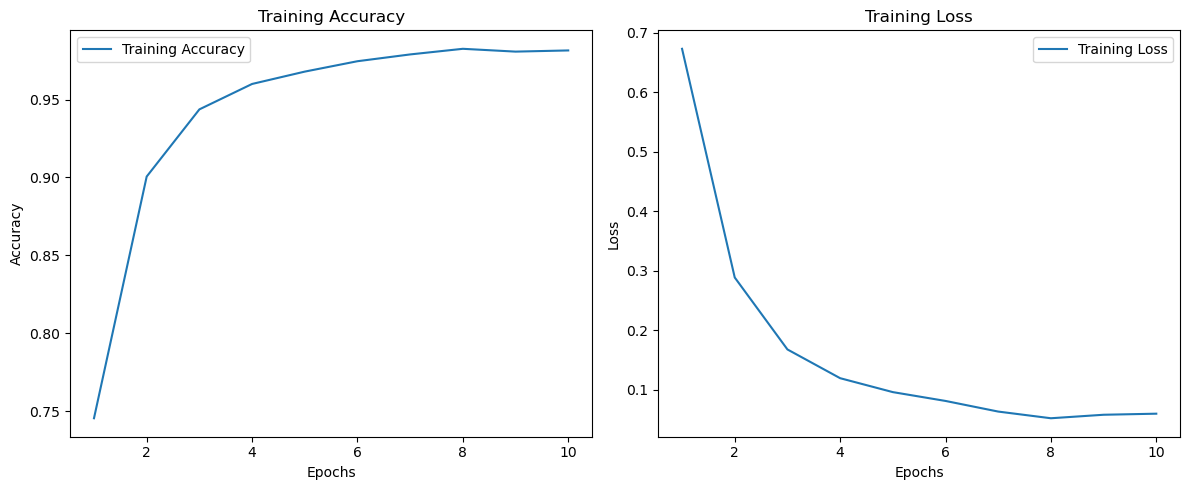

In [11]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss."""
    # Extract data from history
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    # plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    # plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


In [12]:
# 모델 저장
model.save('/workspace/uk/Emotion_Classifier_MoblieNet.h5')

/root/miniconda3/envs/uk/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
